### DS 340H: Final Project
By: Tayae Rogers \
Date: 12/6/2024

In [671]:
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px

In [2]:
os.chdir("/Users/tayaerogers/Desktop/DS340H/FinalProject")

# Data work

## Reading in data

In [ ]:
# Blue Bike rides
june23 = pd.read_csv('Data/202306-bluebikes-tripdata.csv')
july23 = pd.read_csv('Data/202307-bluebikes-tripdata.csv')
aug23 = pd.read_csv('Data/202308-bluebikes-tripdata.csv')

bike_rides = pd.concat([june23, july23, aug23])

In [ ]:
# Blue Bike stations
bike_stations = pd.read_csv('Data/current_bluebikes_stations.csv', header=1)

In [ ]:
# MBTA rides (station ID: codes)
T_rides_Q2 = pd.read_csv('Data/TravelTimes_2023/2023-Q2_HRTravelTimes.csv')
T_rides_Q3 = pd.read_csv('Data/TravelTimes_2023/2023-Q3_HRTravelTimes.csv')

T_rides = pd.concat([T_rides_Q2, T_rides_Q3])

In [ ]:
# MBTA rides recent (station ID: codes and names)
T_rides_for_crosswalk = pd.read_csv('Data/Headways_2024/2024-01_Headway.csv')

/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_31009/2228627966.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  T_rides_for_crosswalk = pd.read_csv('Headways_2024/2024-01_Headway.csv')


In [ ]:
# MBTA stations (station ID: names)
T_stations = gpd.read_file('Data/mbta_rapid_transit/MBTA_NODE.shp')

## Data cleaning

### Blue Bike stations and rides

In [95]:
# Standardizing number of digits for bike stations coordinates
# Tested with 6 digits, but must do 7 to keep uniqueness
bike_stations['Lat_7'] = bike_stations['Lat'].apply(lambda x: f'{x:.7f}')
bike_stations['Long_7'] = bike_stations['Long'].apply(lambda x: f'{x:.7f}')

# Make a df of stations in Cambridge
bike_stations_cambridge = bike_stations[bike_stations['Municipality'] == 'Cambridge'].reset_index(drop=True)
bike_stations_cambridge = bike_stations_cambridge.rename(columns={'Lat':'latitude', 'Long':'longitude'})

# Make a list of stations in Cambridge
bike_stations_cambridge_ls = bike_stations_cambridge['NAME'].to_list()

Number of unique coordinate pairs: 89
Number of unique coordinate pairs (7 digits): 89
--> If the above values are the same, that confirms that coordinates are all the same


In [96]:
# Subset to bike rides that started and ended in Cambridge
bike_rides = bike_rides[(bike_rides['start_station_name'].isin(bike_stations_cambridge_ls)) & (bike_rides['end_station_name'].isin(bike_stations_cambridge_ls))].reset_index(drop=True)

# Calculate travel time (in seconds)
bike_rides['started_at'] = pd.to_datetime(bike_rides['started_at'])
bike_rides['ended_at'] = pd.to_datetime(bike_rides['ended_at'])
bike_rides['travel_time_sec_bike'] = (bike_rides['ended_at'] - bike_rides['started_at']).dt.total_seconds()

# Calculate start and end time in seconds -- so can compare with T start and end times
bike_rides['started_at_sec'] = (bike_rides['started_at'] - bike_rides['started_at'].dt.normalize()).dt.total_seconds()
bike_rides['ended_at_sec'] = (bike_rides['ended_at'] - bike_rides['started_at'].dt.normalize()).dt.total_seconds()

## Round coordinate values to 7 digits
bike_rides['Start_Lat_7'] = bike_rides['start_lat'].apply(lambda x: f'{x:.7f}')
bike_rides['Start_Long_7'] = bike_rides['start_lng'].apply(lambda x: f'{x:.7f}')
bike_rides['End_Lat_7'] = bike_rides['end_lat'].apply(lambda x: f'{x:.7f}')
bike_rides['End_Long_7'] = bike_rides['end_lng'].apply(lambda x: f'{x:.7f}')

## Make sure the start and end locations are the same (there's no value in one set that's not in the other)
# Create coordinate tuples
bike_rides['Start_Tuples'] = bike_rides.apply(lambda row: (row['start_lat'], row['start_lng']), axis=1)
bike_rides['End_Tuples'] = bike_rides.apply(lambda row: (row['end_lat'], row['end_lng']), axis=1)

# Create coordinate 7-digit tuples
bike_rides['Start_7_Tuples'] = bike_rides.apply(lambda row: (row['Start_Lat_7'], row['Start_Long_7']), axis=1)
bike_rides['End_7_Tuples'] = bike_rides.apply(lambda row: (row['End_Lat_7'], row['End_Long_7']), axis=1)

# Confirm that 
print('Number of unique start coordinate pairs: ' + str(len(bike_rides['Start_Tuples'].unique())))
print('Number of unique end coordinate pairs: ' +str(len(bike_rides['End_Tuples'].unique())))
print('Number of unique start coordinate pairs (7 digits): ' + str(len(bike_rides['Start_7_Tuples'].unique())))
print('Number of unique end coordinate pairs (7 digits): ' +str(len(bike_rides['End_7_Tuples'].unique())))
print('Number of unique start and/or end coordinate pairs (7 digits): ' + str(len(set(bike_rides['Start_7_Tuples'].unique()).intersection(set(bike_rides['End_7_Tuples'].unique())))))
print('--> If the above values are the same, that confirms that start and end coordinates are all the same')

# Save to csv
# bike_rides.to_csv("Bike_Rides_Cambridge.csv")

Number of unique start coordinate pairs: 81
Number of unique end coordinate pairs: 81
Number of unique start coordinate pairs (7 digits): 81
Number of unique end coordinate pairs (7 digits): 81
Number of unique start and/or end coordinate pairs (7 digits): 81
--> If the above values are the same, that confirms that start and end coordinates are all the same


In [ ]:
# Select unique coordinate sets for bike stations
# Using this rather than a subset of the bike stations data because the two datasets give slightly different coordinates (and this is an issue when scraping)
bike_stations_cambridge_from_rides = bike_rides[['Start_Lat_7', 'Start_Long_7']].drop_duplicates()

### T stations

In [99]:
# Calculate longitude and latitude values for each coordinate geometry point
# Convert from NAD83 to regular coordinates
def convert_longLat(geo_df):
    inProj = Proj(init="epsg:26986", preserve_units=True)
    outProj = Proj(init='epsg:4326')

    long_conv, lat_conv = transform(inProj, outProj, geo_df.geometry.x, geo_df.geometry.y)

    geo_df['latitude'] = lat_conv
    geo_df['longitude'] = long_conv

    return geo_df

T_stations = convert_longLat(T_stations)

/Users/tayaerogers/miniconda3/envs/proj2/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/tayaerogers/miniconda3/envs/proj2/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_31009/1825606655.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/st

In [101]:
# Subsetting to T stations in Cambridge
cambridge_station_ls = ['Alewife', 'Central', 'Harvard', 'Kendall/MIT', 'Porter'] 
T_stations_cambridge = T_stations[T_stations['STATION'].isin(cambridge_station_ls)]

# Standardize number of digits
T_stations_cambridge['Lat_7'] = T_stations_cambridge['latitude'].apply(lambda x: f'{x:.7f}')
T_stations_cambridge['Long_7'] = T_stations_cambridge['longitude'].apply(lambda x: f'{x:.7f}')

# Save to CSV
# T_stations_cambridge.to_csv("TStations_Cambridge.csv")

/Users/tayaerogers/miniconda3/envs/proj2/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tayaerogers/miniconda3/envs/proj2/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


STATION LINE TERMINUS                                    ROUTE  \
56      Harvard  RED        N  A - Ashmont  B - Braintree  C - Alewife   
57  Kendall/MIT  RED        N  A - Ashmont  B - Braintree  C - Alewife   
87      Alewife  RED        Y  A - Ashmont  B - Braintree  C - Alewife   
88       Porter  RED        N  A - Ashmont  B - Braintree  C - Alewife   
89      Central  RED        N  A - Ashmont  B - Braintree  C - Alewife   

                         geometry   latitude  longitude       Lat_7  \
56  POINT (231387.274 902684.016)  42.374029 -71.118906  42.3740292   
57  POINT (234087.917 901406.551)  42.362415 -71.086191  42.3624153   
87  POINT (229468.582 905129.626)  42.396121 -71.142077  42.3961210   
88  POINT (231363.042 904271.357)  42.388320 -71.119114  42.3883205   
89  POINT (232633.774 901735.613)  42.365440 -71.103825  42.3654399   

         Long_7  
56  -71.1189061  
57  -71.0861915  
87  -71.1420773  
88  -71.1191142  
89  -71.1038252

### T rides/trains

In [102]:
# Subset to T rides taken in summer 2023
T_rides['service_date'] = pd.to_datetime(T_rides['service_date'])
T_rides = T_rides[(T_rides['service_date'] >= '2023-06-01') & (T_rides['service_date'] < '2023-09-01')].reset_index(drop=True)

# Revise service date, start time, and end time
# Based on data source notes
# If start_time_sec > the # of seconds in a day --> adjust the day, start_time_sec, and end_time_sec accordingly
# If only end_time_sec > the # of seconds in a day --> leave it (othwerise, will get negative values in subtraction later on)
T_rides.loc[T_rides['start_time_sec'] >= 60*60*24, 'service_date'] += datetime.timedelta(days=1)
T_rides.loc[T_rides['start_time_sec'] >= 60*60*24, 'end_time_sec'] -= 60*60*24
T_rides.loc[T_rides['start_time_sec'] >= 60*60*24, 'start_time_sec'] -= 60*60*24

# Data quality check
# print(T_rides['start_time_sec'].describe())
# print(T_rides['start_time_sec'].max() < 60*60*24)

count    7.733554e+06
mean     5.044721e+04
std      2.101867e+04
min      0.000000e+00
25%      3.380500e+04
50%      5.116800e+04
75%      6.776900e+04
max      8.639900e+04
Name: start_time_sec, dtype: float64
True


In [104]:
# Ensure can match stop ID to Cambridge stop
# Stop IDs as strings
T_rides_for_crosswalk['stop_id'] = T_rides_for_crosswalk['stop_id'].astype(str)

# Cambridge stops
cambridge_stop_ids = []

# Make list with all T stop IDs that correspond to a T stop in Cambridge
for station in cambridge_station_ls:
    cambridge_stop_ids.extend(T_rides_for_crosswalk['stop_id'][T_rides_for_crosswalk['stop_name'] == station].unique())

# Confirm that each stop ID identifies a unique stop
for stop in cambridge_stop_ids:
    print(len(T_rides_for_crosswalk['stop_name'][T_rides_for_crosswalk['stop_id'] == stop].unique()))

print('--> Given that these are all 1, confirms we can directly crosswalk')

# Based on this, will make a dictionary in the next cell

1
1
1
1
1
1
1
1
1
1
1
--> Given that these are all 1, confirms we can directly crosswalk


In [ ]:
# Subset T rides to just T stops in Cambridge
T_rides['from_stop_id'] = T_rides['from_stop_id'].astype(str)
T_rides['to_stop_id'] = T_rides['to_stop_id'].astype(str)

T_rides_cambridge = T_rides[(T_rides['from_stop_id'].isin(cambridge_stop_ids)) & (T_rides['to_stop_id'].isin(cambridge_stop_ids))].reset_index(drop=True)

# Change to date object
T_rides_cambridge['service_date'] = pd.to_datetime(T_rides_cambridge['service_date']).dt.date

# Make a dictionary to crosswalk from station ID to station name
cambridge_stop_ids_dict = {}

for stop in cambridge_stop_ids:
    cambridge_stop_ids_dict[stop] = T_rides_for_crosswalk['stop_name'][T_rides_for_crosswalk['stop_id'] == stop].unique()

# Apply crosswalk (that used values from T_rides_for_crosswalk) to identify the name of each stop in T_rides_cambridge
T_rides_cambridge['from_stop_name'] = T_rides_cambridge.apply(lambda row: cambridge_stop_ids_dict[row['from_stop_id']][0], axis=1)
T_rides_cambridge['to_stop_name'] = T_rides_cambridge.apply(lambda row: cambridge_stop_ids_dict[row['to_stop_id']][0], axis=1)

# Make a dictionary to crosswalk from station name to station coordinates
cambridge_stop_ids_coords = {}

for station in T_stations_cambridge['STATION']:
    cambridge_stop_ids_coords[station] = str((T_stations_cambridge[T_stations_cambridge['STATION'] == station]['Lat_7'].unique()[0], T_stations_cambridge[T_stations_cambridge['STATION'] == station]['Long_7'].unique()[0]))

# Apply crosswalk (that used values from T_stations_cambridge) to identify the coordinates of each stop in T_rides_cambridge
T_rides_cambridge['from_stop_coords_7'] = T_rides_cambridge.apply(lambda row: cambridge_stop_ids_coords[row['from_stop_name']], axis=1)
T_rides_cambridge['to_stop_coords_7'] = T_rides_cambridge.apply(lambda row: cambridge_stop_ids_coords[row['to_stop_name']], axis=1)

# Save to CSV
# T_rides_cambridge.to_csv("Summer2023_HRTravelTimes_Cambridge.CSV")

## Mapping routes

### Bike station to T station walking time (dictionary)

In [420]:
# Create a dictionary with keys: bike station coordinates, values: dictionary with T station keys and walking time from the bike station to T station values
# Goal structure: {(bike_station_lat, bike_station_long): {(MBTA_station_lat1, MBTA_station_long1): walking_time_from_google_maps_api1, (MBTA_station_lat2, MBTA_station_long2): walking_time_from_google_maps_api2, etc}}
bikeStation_TStation_dist_dict={}
key='' # INSERT OWN KEY

# Iterates through bike station
for row_bike,index_bike in bike_stations_cambridge_from_rides.iterrows():

    # print('Current bike station: ' + index_bike['NAME'])
    bike_station_coords=str(index_bike['Start_Lat_7']) + ',' + str(index_bike['Start_Long_7'])
    one_bike_station_dict={}

    for row_T, index_T in T_stations_cambridge.iterrows():
        destination=str(index_T['Lat_7']) + ',' + str(index_T['Long_7'])
        print(destination)
        response = requests.get(f"https://maps.googleapis.com/maps/api/directions/json?destination={destination}&mode=walking&origin={bike_station_coords}&key={key}")
        walking_time = response.json()['routes'][0]['legs'][0]['duration']['value']
        one_bike_station_dict[str((index_T['Lat_7'], index_T['Long_7']))] = walking_time
        
    bikeStation_TStation_dist_dict[str((index_bike['Start_Lat_7'], index_bike['Start_Long_7']))] = one_bike_station_dict
   
with open("bikeStation_TStation_dict.json", "w") as outfile: 
    json.dump(bikeStation_TStation_dist_dict, outfile)

42.3740292,-71.1189061
42.3624153,-71.0861915
42.3961210,-71.1420773
42.3883205,-71.1191142
42.3654399,-71.1038252
42.3740292,-71.1189061
42.3624153,-71.0861915
42.3961210,-71.1420773
42.3883205,-71.1191142
42.3654399,-71.1038252
42.3740292,-71.1189061
42.3624153,-71.0861915
42.3961210,-71.1420773
42.3883205,-71.1191142
42.3654399,-71.1038252
42.3740292,-71.1189061
42.3624153,-71.0861915
42.3961210,-71.1420773
42.3883205,-71.1191142
42.3654399,-71.1038252
42.3740292,-71.1189061
42.3624153,-71.0861915
42.3961210,-71.1420773
42.3883205,-71.1191142
42.3654399,-71.1038252
42.3740292,-71.1189061
42.3624153,-71.0861915
42.3961210,-71.1420773
42.3883205,-71.1191142
42.3654399,-71.1038252
42.3740292,-71.1189061
42.3624153,-71.0861915
42.3961210,-71.1420773
42.3883205,-71.1191142
42.3654399,-71.1038252
42.3740292,-71.1189061
42.3624153,-71.0861915
42.3961210,-71.1420773
42.3883205,-71.1191142
42.3654399,-71.1038252
42.3740292,-71.1189061
42.3624153,-71.0861915
42.3961210,-71.1420773
42.3883205,

### Bike station to other bike station walking time (dictionary)

In [424]:
# Create a dictionary with keys: bike station coordinates, values: dictionary with bike station keys and walking time from the first bike station to second bike station values
# Goal structure: {(bike_station_lat1, bike_station_long1): {(bike_station_lat2, bike_station_long2): walking_time_from_google_maps_api1, (bike_station_lat3, bike_station_long3): walking_time_from_google_maps_api2, etc}}
bikeStation_bikeStation_dist_dict={}
key='' # INSERT OWN KEY

# Iterates through bike station
for row_bike,index_bike in bike_stations_cambridge_from_rides.iterrows():

    # print('Current bike station: ' + index_bike['NAME'])
    bike_station_coords=str(index_bike['Start_Lat_7']) + ',' + str(index_bike['Start_Long_7'])
    one_bike_station_dict={}

    for row_bike2, index_bike2 in bike_stations_cambridge_from_rides.iterrows():
        destination=str(index_bike2['Start_Lat_7']) + ',' + str(index_bike2['Start_Long_7'])
        print(destination)
        try:
            response = requests.get(f"https://maps.googleapis.com/maps/api/directions/json?destination={destination}&mode=walking&origin={bike_station_coords}&key={key}", timeout=10)
            walking_time = response.json()['routes'][0]['legs'][0]['duration']['value']
            one_bike_station_dict[str((index_bike2['Start_Lat_7'], index_bike2['Start_Long_7']))] = walking_time
        except:
            one_bike_station_dict[str((index_bike2['Start_Lat_7'], index_bike2['Start_Long_7']))] = np.nan
            print('*** NAN VALUE *** between ' + str(index_bike['Start_Lat_7']) + ',' + str(index_bike['Start_Long_7']) + ' and ' + str(index_bike2['Start_Lat_7']) + ',' + str(index_bike2['Start_Long_7']))
        
    bikeStation_bikeStation_dist_dict[str((index_bike['Start_Lat_7'], index_bike['Start_Long_7']))] = one_bike_station_dict

# Write to JSON
# with open("bikeStation_bikeStation_dist_dict.json", "w") as outfile:
#    json.dump(bikeStation_bikeStation_dist_dict, outfile)

42.3622420,-71.0831110
42.3624280,-71.0849550
42.3955880,-71.1426060
42.3912100,-71.1226080
42.3711970,-71.0975990
42.3853680,-71.1377570
42.3664260,-71.1054950
42.3733290,-71.1209860
42.3613580,-71.0967030
42.3630450,-71.0828710
42.3894560,-71.1390190
42.3617800,-71.1081000
42.3807880,-71.1541290
42.3961050,-71.1394590
42.3867480,-71.1190190
42.3708030,-71.1044120
42.3629020,-71.0915670
42.3664200,-71.0885420
42.3605420,-71.0866980
42.3666210,-71.1142140
42.3626480,-71.1000610
42.3625000,-71.0882200
42.3630040,-71.0897400
42.3779450,-71.1168650
42.3576620,-71.1084130
42.3711410,-71.0761980
42.3730800,-71.0863420
42.3689520,-71.1099880
42.3621310,-71.0911560
42.3695530,-71.0857900
42.3719770,-71.0720050
42.3650700,-71.1031000
42.3698850,-71.0699570
42.3742670,-71.1002650
42.3670740,-71.0767930
42.3595730,-71.1012950
42.3581000,-71.0931980
42.3732680,-71.1185790
42.3636930,-71.0875670
42.3720770,-71.0899540
42.3879950,-71.1190840
42.3816510,-71.1342700
42.3635600,-71.0821680
42.3733790,

In [483]:
# Returns NAN once: Between 42.3576620,-71.1084130 and 42.3608590,-71.0855190
# Manual debugging
key='' # INSERT OWN KEY

start = str(('42.3576620', '-71.1084130'))
end = str(('42.3608590', '-71.0855190'))

response = requests.get(f"https://maps.googleapis.com/maps/api/directions/json?destination={end}&mode=walking&origin={start}&key={key}", timeout=10)
print(response.json())
# --> Doesn't work (unclear why)
# Manually searched in Google Maps --> 32 minutes (canot get seconds)

bikeStation_bikeStation_dist_dict[str(('42.3576620', '-71.1084130'))][str(('42.3608590', '-71.0855190'))] = 32*60

{'geocoded_waypoints': [{'geocoder_status': 'ZERO_RESULTS'}, {'geocoder_status': 'ZERO_RESULTS'}], 'routes': [], 'status': 'NOT_FOUND'}


## Building comprehensive bike rides dataset with corresponding T routes

### "T" Scenario 1: Fastest "T" route is walking from start bike station to end bike station

In [ ]:
bike_rides['travel_time_sec_walk'] = bike_rides.apply(lambda row: bikeStation_bikeStation_dist_dict[row['Start_7_Tuples']][row['End_7_Tuples']], axis=1)
bike_rides['ended_at_walk'] = bike_rides.apply(lambda row: row['started_at_sec'] + row['travel_time_sec_walk'], axis=1)

### "T" Scenario 2: Fastest "T" route is walking --> riding T --> walking

In [ ]:
# Coordinates of T station closest to start
bike_rides['start_closest_T_coords'] = bike_rides.apply(lambda row: min(bikeStation_TStation_dist_dict[row['Start_7_Tuples']], key=bikeStation_TStation_dist_dict[row['Start_7_Tuples']].get), axis=1) # Note: Could've used 'Start_7_Tuples' and 'End_7_Tuples'

# Time of arrival at T station closest to start (walking)
bike_rides['start_closest_T_arrive'] = bike_rides.apply(lambda row: (row['started_at_sec'] + min(bikeStation_TStation_dist_dict[row['Start_7_Tuples']].values())), axis=1) # Note: Could've used 'Start_7_Tuples'

# Coordinates of T station closest to end
bike_rides['end_closest_T_coords'] = bike_rides.apply(lambda row: min(bikeStation_TStation_dist_dict[row['End_7_Tuples']], key=bikeStation_TStation_dist_dict[row['End_7_Tuples']].get), axis=1) # Note: Could've used 'End_7_Tuples'

In [186]:
def arrive_at_Tstation_end(row):
    print('Ride ID: ' + row['ride_id'])

    start_coords = str((row['Start_Lat_7'],row['Start_Long_7']))
    end_coords = str((row['End_Lat_7'],row['End_Long_7']))
    start_T_coords = row['start_closest_T_coords']
    end_T_coords = row['end_closest_T_coords']
    date = pd.to_datetime(row['started_at']).date()
    T_start_time = row['start_closest_T_arrive']

    if start_coords == end_coords: # Case: Start and end coordinates are the same
        return row['ended_at_walk'] # It's okay to return 0 here because 'walking' will also return 0

    elif start_T_coords == end_T_coords: # Case: Start and end coordinates are different, but the closest T station to start and the closest T station to end coordiantes are the same
        return row['ended_at_walk'] # This case should also cover the former case (i.e. only this case should be necessary) but I'm separating it out to be safe

    elif len(T_rides_cambridge[(T_rides_cambridge['from_stop_coords_7'] == start_T_coords) & (T_rides_cambridge['to_stop_coords_7'] == end_T_coords) & (T_rides_cambridge['service_date'] == date) & (T_rides_cambridge['start_time_sec'] > T_start_time)]) > 0: # Case: There is a next available train on that day same day
        T_index = T_rides_cambridge['start_time_sec'][(T_rides_cambridge['from_stop_coords_7'] == start_T_coords) & (T_rides_cambridge['to_stop_coords_7'] == end_T_coords) & (T_rides_cambridge['service_date'] == date) & (T_rides_cambridge['start_time_sec'] > T_start_time)].idxmin()
        return T_rides_cambridge.loc[T_index]['end_time_sec']
    
    else: # Case: Other (next available train is on the next day)
        try:
            T_index = T_rides_cambridge['start_time_sec'][(T_rides_cambridge['from_stop_coords_7'] == start_T_coords) & (T_rides_cambridge['to_stop_coords_7'] == end_T_coords) & (T_rides_cambridge['service_date'] == (date + datetime.timedelta(days=1)))].idxmin()
            return (T_rides_cambridge.loc[T_index]['end_time_sec']+86400)
        except:
            print('ERROR')
            return np.nan

# Time arrive at T station closest to the end
bike_rides['end_closest_T_arrive'] = bike_rides.apply(arrive_at_Tstation_end, axis=1)

Ride ID: DE1C7C6C734C79CC
Ride ID: 6F5BFB3BD760EB8E
Ride ID: D7B13F62B8F1B6FA
Ride ID: 287EBB712394FC15
Ride ID: FEDAEE827B829FCC
Ride ID: 31560BD8EA5C3F37
Ride ID: D679C0F1EB0EF742
Ride ID: A7E5D1155DFA4512
Ride ID: E48473B9BCF8165F
Ride ID: 376A04B5070ED824
Ride ID: A67352265E7C463E
Ride ID: F6E73850EF64D84E
Ride ID: C698D11079DDB634
Ride ID: BA86962CACFBE504
Ride ID: E197EA02E1AF0B92
Ride ID: D4F282E3B557D304
Ride ID: 5E016747289C12AF
Ride ID: DD6303CB037B76D7
Ride ID: F1177002C44644B0
Ride ID: A281FC1A866A3D99
Ride ID: 2AEABB2BB1ADFA8F
Ride ID: 20D9136F445F78CF
Ride ID: 11969A5A98B732D3
Ride ID: E8B8B252E3DC3D37
Ride ID: 6AA76ED05BDE8E3C
Ride ID: D06842465E226A60
Ride ID: 28AB773614715B16
Ride ID: CB9E5C2BB8069CD1
Ride ID: 01D4E1122CFFDDD2
Ride ID: 9EFFBB35CA8A1FAD
Ride ID: 489445E451C04DA1
Ride ID: 4E1988002C2B5B4A
Ride ID: 53B628096EAD6FD3
Ride ID: 186DE59147615776
Ride ID: 2565F0087D04D0FA
Ride ID: 7C1288152DE3984A
Ride ID: 7D4CDAE096E61E38
Ride ID: 251382E445E19CB6
Ride ID: 898

In [520]:
# Calculate time ended at and total travel time via T route
bike_rides['ended_at_T'] = bike_rides.apply(lambda row: row['end_closest_T_arrive'] + bikeStation_TStation_dist_dict[row['End_7_Tuples']][row['end_closest_T_coords']], axis=1)
bike_rides['travel_time_sec_T'] = bike_rides['ended_at_T']-bike_rides['started_at_sec']

# Find the minimum public transit route time
bike_rides['travel_time_publicTransit'] = bike_rides.apply(lambda row: min(row['travel_time_sec_T'], row['travel_time_sec_walk']), axis=1)

count    239208.000000
mean       1593.971050
std        3952.207282
min      -86125.000000
25%        1115.000000
50%        1566.000000
75%        2098.000000
max       50110.000000
Name: travel_time_sec_T, dtype: float64
--> There are definitely some outliers, but of all the rides, only 0.62% are started during regular T hours AND take an unusally long amount of time
--> To compensate, will proceed with median value


# Analysis and Visualization

## Initial Analysis

In [702]:
## Drop if walking time == 0
print('Dropping routes with walking time == 0 because they do not seem to be about efficient travel')
perc_walk = len(bike_rides[bike_rides['travel_time_sec_walk'] == 0])/len(bike_rides) 
print('Note that ' + str(round(perc_walk,3)) + '% of trips have walking time == 0')

bike_rides_no0 = bike_rides[bike_rides['travel_time_sec_walk'] != 0]

## Adding these variables potentially for regression later
bike_rides_no0['start_walk'] = bike_rides_no0['start_closest_T_arrive'] - bike_rides_no0['started_at_sec']
bike_rides_no0['end_walk'] = bike_rides_no0['ended_at_T'] - bike_rides_no0['end_closest_T_arrive']

## Group by
grouped = bike_rides_no0.groupby(['Start_7_Tuples', 'End_7_Tuples', 'start_walk', 'end_walk', 'Start_Lat_7', 'Start_Long_7', 'start_station_name']).aggregate({'travel_time_sec_bike': 'median', 'travel_time_sec_T':'median', 'travel_time_sec_walk':'median', 'travel_time_publicTransit':'median', 'ride_id': 'count'}).reset_index()
grouped.rename(columns={'ride_id':'count'}, inplace=True)

## Group by subset -- at least 10 rides
grouped_atleast10 = grouped[grouped['count'] >= 10]

## Group -- during MBTA hours
end_service_sec = 5*60
start_service_sec = 60*60*6+5*60

bike_rides_day = bike_rides_no0[(bike_rides_no0['started_at_sec'] > end_service_sec) & (bike_rides_no0['started_at_sec'] > start_service_sec)]
grouped_day = bike_rides_day.groupby(['Start_7_Tuples', 'End_7_Tuples', 'start_walk', 'end_walk']).aggregate({'travel_time_sec_bike': 'median', 'travel_time_sec_T':'median', 'travel_time_sec_walk':'median', 'travel_time_publicTransit':'median', 'ride_id': 'count'}).reset_index()
grouped_day.rename(columns={'ride_id':'count'}, inplace=True)
grouped_day_atleast10 = grouped_day[grouped_day['count'] >= 10]

Dropping routes with walking time == 0 because they do not seem to be about efficient travel
Note that 0.062% of trips have walking time == 0


/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_31009/3968926464.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_rides_no0['start_walk'] = bike_rides_no0['start_closest_T_arrive'] - bike_rides_no0['started_at_sec']
/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_31009/3968926464.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_rides_no0['end_walk'] = bike_rides_no0['ended_at_T'] - bike_rides_no0['end_closest_T_arrive']


In [703]:
### Analysis 1 ### -- INITIAL
## Analysis : % of routes faster
perc_faster_bikeshare = len(grouped[grouped['travel_time_sec_bike'] < grouped['travel_time_publicTransit']])/len(grouped) # --> 95.5% of routes are faster via bike than via T/walk
print("The proportion of start/stop bikeshare station combinations for which bikeshare is faster than taking the T or walking: " + str(round(perc_faster_bikeshare*100, 3)) + "%")

## Interpretation
grouped['travel_time_diff'] = grouped['travel_time_sec_bike'] - grouped['travel_time_publicTransit']
print("On average, bikeshare is " + str(round(-1*(grouped['travel_time_diff'].mean()/60),3)) + " minutes faster than the alternative T/walking route")

### Analysis 2 ### -- PRIMARY
## Analysis : % of routes faster
grouped_atleast10['travel_time_diff'] = grouped_atleast10['travel_time_sec_bike'] - grouped_atleast10['travel_time_publicTransit']
perc_faster_bikeshare = len(grouped_atleast10[grouped_atleast10['travel_time_sec_bike'] < grouped_atleast10['travel_time_publicTransit']])/len(grouped_atleast10) # --> 95.5% of routes are faster via bike than via T/walk
print("The proportion of start/stop bikeshare station combination (with at least 10 rides) for which bikeshare is faster than taking the T or walking: " + str(round(perc_faster_bikeshare*100, 3)) + "%")

## Interpretation
print("On average, bikeshare is " + str(round(-1*(grouped['travel_time_diff'][grouped['count'] >= 10].mean()/60),3)) + " minutes faster than the alternative T/walking route")

### Analysis 3 ### -- GUT CHECK
## Analysis : % of routes faster
grouped_day_atleast10['travel_time_diff'] = grouped_day_atleast10['travel_time_sec_bike'] - grouped_day_atleast10['travel_time_publicTransit']
perc_faster_bikeshare = len(grouped_day_atleast10[grouped_day_atleast10['travel_time_sec_bike'] < grouped_day_atleast10['travel_time_publicTransit']])/len(grouped_day_atleast10) # --> 95.5% of routes are faster via bike than via T/walk
print("The proportion of start/stop bikeshare station combination (with at least 10 rides and taken during MBTA service hours) for which bikeshare is faster than taking the T or walking: " + str(round(perc_faster_bikeshare*100, 3)) + "%")

## Analysis
print("On average, bikeshare is " + str(round(-1*(grouped_day_atleast10['travel_time_diff'][grouped_day_atleast10['count'] >= 10].mean()/60),3)) + " minutes faster than the alternative T/walking route")

The proportion of start/stop bikeshare station combinations for which bikeshare is faster than taking the T or walking: 95.694%
On average, bikeshare is 12.276 minutes faster than the alternative T/walking route
The proportion of start/stop bikeshare station combination (with at least 10 rides) for which bikeshare is faster than taking the T or walking: 97.098%
On average, bikeshare is 12.506 minutes faster than the alternative T/walking route
The proportion of start/stop bikeshare station combination (with at least 10 rides and taken during MBTA service hours) for which bikeshare is faster than taking the T or walking: 96.959%
On average, bikeshare is 12.409 minutes faster than the alternative T/walking route


/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_31009/2432788147.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_atleast10['travel_time_diff'] = grouped_atleast10['travel_time_sec_bike'] - grouped_atleast10['travel_time_publicTransit']
/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_31009/2432788147.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_day_atleast10['travel_time_diff'] = grouped_day_atleast10['travel_time_sec_bike'] - grouped_day_atleast10['travel_t

In [704]:
(grouped_atleast10['travel_time_diff']/60).describe()

count    3618.000000
mean      -12.506095
std         8.327590
min       -66.116667
25%       -16.845833
50%       -12.000000
75%        -7.433333
max        40.883333
Name: travel_time_diff, dtype: float64

## Initial Visualization

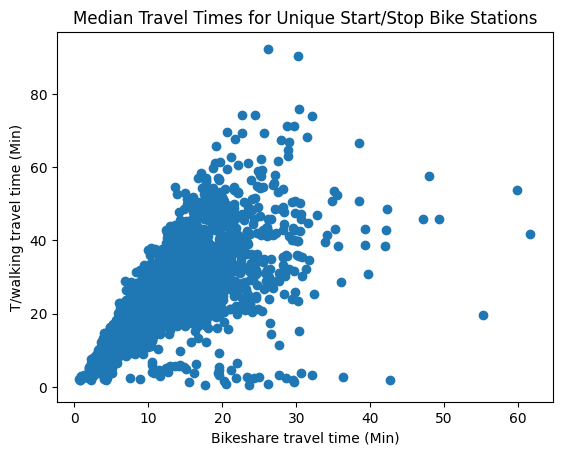

In [706]:
# Scatterplot
plt.scatter(grouped_atleast10['travel_time_sec_bike']/60, grouped_atleast10['travel_time_publicTransit']/60)
plt.title("Median Travel Times for Unique Start/Stop Bike Stations")
plt.xlabel("Bikeshare travel time (Min)")
plt.ylabel("T/walking travel time (Min)")
plt.show()

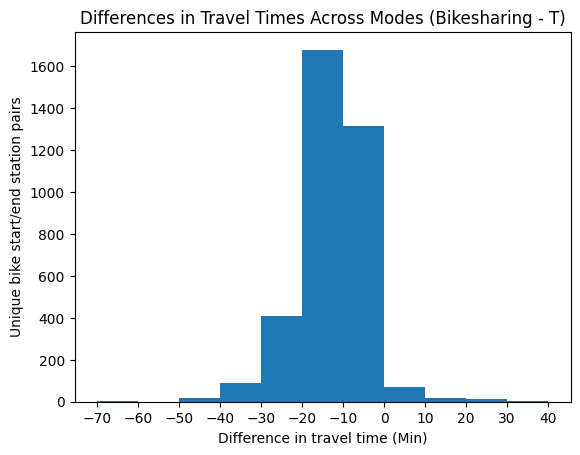

In [705]:
# Histogram
plt.hist(grouped_atleast10['travel_time_diff']/60, bins=np.arange(-70,50,step=10))
plt.title("Differences in Travel Times Across Modes (Bikesharing - T)")
plt.xlabel("Difference in travel time (Min)")
plt.ylabel("Unique bike start/end station pairs")
plt.xticks(np.arange(-70,50,step=10))
plt.show()

In [767]:
# Map - Start bike stations and T stations, colored by the average difference of travel times across start/stop pairs that start there
grouped_atleast10_bystart = grouped_atleast10.groupby(['Start_Lat_7','Start_Long_7','start_station_name']).aggregate({'travel_time_diff':'mean'}).reset_index()

T_station_cambridge_map = T_stations_cambridge.groupby(['STATION', 'Lat_7', 'Long_7']).size().reset_index()
T_station_cambridge_map['Lat_7'] = pd.to_numeric(T_station_cambridge_map['Lat_7'])
T_station_cambridge_map['Long_7'] = pd.to_numeric(T_station_cambridge_map['Long_7'])
T_station_cambridge_map['STATION'] = 'T STATION: ' + T_station_cambridge_map['STATION']

fig = px.scatter_mapbox(
    grouped_atleast10_bystart,
    lat='Start_Lat_7',
    lon='Start_Long_7',
    hover_name='start_station_name',  # Display station name on hover
    hover_data={'Start_Lat_7': False, 'Start_Long_7': False, 'travel_time_diff': True},  # Hide lat/lng, show total rides
    color='travel_time_diff',
    color_continuous_scale=px.colors.sequential.Bluered,  # Apply a color gradient
    zoom=12,
    opacity=1,  # Increase opacity for better visibility
    mapbox_style='carto-positron',
    width=900,
    height=600
)

fig.add_trace(px.scatter_mapbox(T_station_cambridge_map, lat="Lat_7", lon="Long_7", hover_name="STATION",color=0).data[0])
fig.update_layout(title='Bikeshare Stations By Mean Difference in Travel Time Across Starting Point Routes')


fig.show()

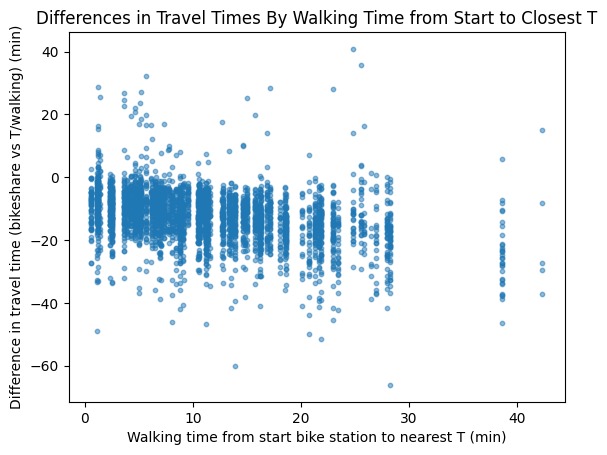

In [682]:
# Scatter: Motivating regression
grouped_day_atleast10 = grouped_day_atleast10.sort_values(by='start_walk')

plt.scatter(grouped_day_atleast10['start_walk']/60, grouped_day_atleast10['travel_time_diff']/60, s=10, alpha=0.5)

plt.title("Differences in Travel Times By Walking Time from Start to Closest T")
plt.xlabel("Walking time from start bike station to nearest T (min)")
plt.ylabel("Difference in travel time (bikeshare vs T/walking) (min)")
plt.show()

## Model: Regression

In [649]:
# Variables in new units for interpretation (but tbh this is not necessary bc converting both variables)
grouped_atleast10['start_walk_min'] = grouped_atleast10['start_walk']/60
grouped_atleast10['travel_time_diff_min'] = grouped_atleast10['travel_time_diff']/60

/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_31009/3412745026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_atleast10['start_walk_min'] = grouped_atleast10['start_walk']/60
/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_31009/3412745026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_atleast10['travel_time_diff_min'] = grouped_atleast10['travel_time_diff']/60


In [650]:
# Regression 1: Unweighted
unweighted_model = smf.ols('travel_time_diff_min ~ start_walk_min', data=grouped_atleast10).fit()
print(unweighted_model.summary())

                             OLS Regression Results                             
Dep. Variable:     travel_time_diff_min   R-squared:                       0.119
Model:                              OLS   Adj. R-squared:                  0.119
Method:                   Least Squares   F-statistic:                     487.4
Date:                  Fri, 06 Dec 2024   Prob (F-statistic):          1.98e-101
Time:                          02:56:23   Log-Likelihood:                -12573.
No. Observations:                  3618   AIC:                         2.515e+04
Df Residuals:                      3616   BIC:                         2.516e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -8.235